In [2]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import pylab as pl
import os
import json

if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [193]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

I am using geopanda. that is **not required** for this particular exercise, but geopand works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!


## An interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". For example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.
## So let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?

## Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

## Either obtain the data through the API or download the csv file, and move it to $PUIDATA

## However this datasets does not have the number of units. We can find that in the Pluto dataset.

## Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [3]:
#download, and move data to PUIDATA, and read data in 
nrg =pd.read_csv(os.getenv('PUIDATA')+
                 '/Energy_and_Water_Data_Disclosure_for_Local_Law__2014_.csv')
bsize =gp.GeoDataFrame.from_file(os.getenv('PUIDATA')+'/Manhattan/MNMapPLUTO.shp')

In [4]:
nrg.head(3)

,Record Number,"NYC Borough, Block, and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identification Numbers (BINs),Street Number,Street Name,Borough,Zip Code,BBL on the Covered Buildings List,...,Automatic Water Benchmarking Eligible,Reported Water Method,ENERGY STAR Score,Total GHG Emissions(MtCO2e),Direct GHG Emissions(MtCO2e),Indirect GHG Emissions(MtCO2e),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings
0,2734969.0,1010950035,NaN,NaN,1027122,653,11 AVENUE,MANHATTAN,10036.0,Yes,...,No,Manual,31,1190.2,345.2,845,153363,153363.0,Hotel,1.0
1,2741228.0,1021390017,NaN,NaN,1063400,1050,RIVERSIDE DRIVE,MANHATTAN,10032.0,Yes,...,No,None,20,4573.1,0,4573.1,256013,213214.0,Office,1.0
2,3108893.0,1008020056,NaN,NaN,1015051,122,WEST 27 STREET,MANHATTAN,10001.0,Yes,...,No,None,78,698.5,302.6,395.9,117291,117291.0,Office,1.0


In [5]:
del nrg['Record Number']

In [7]:
# make sure you clean up your data and throw away columns you do not need!

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbbd8d25710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fbbd9541f60>]], dtype=object)

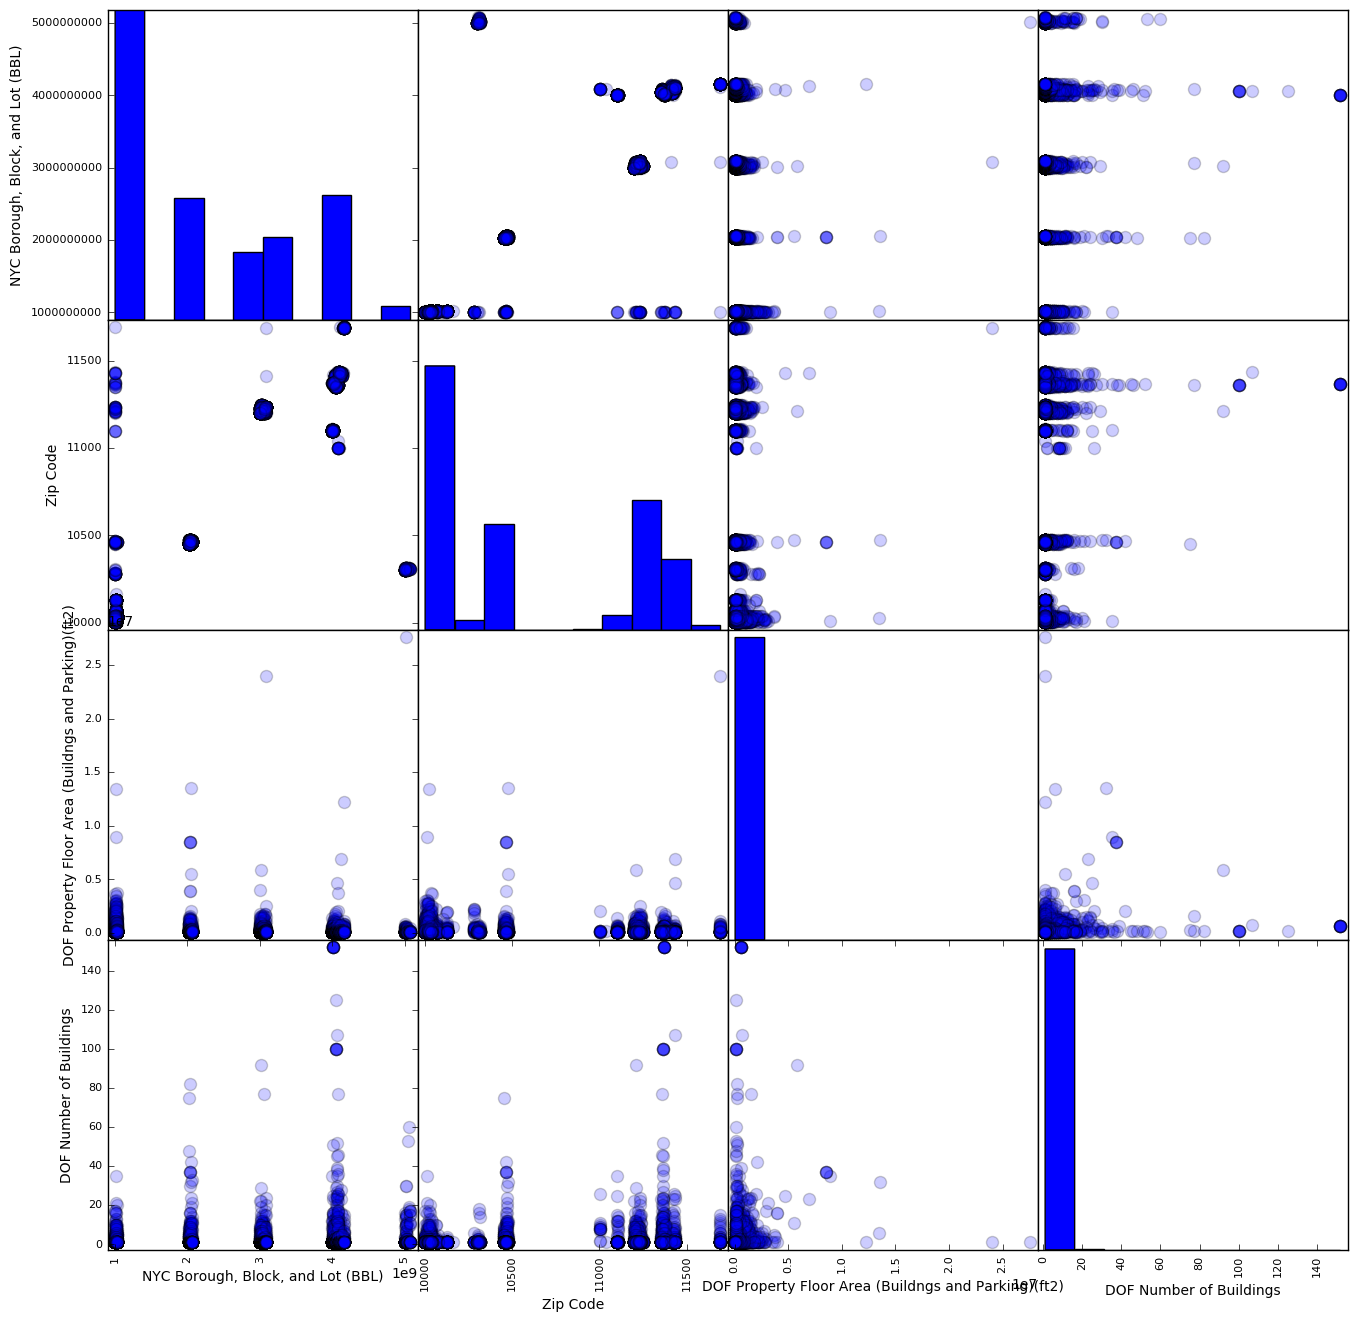

In [8]:
#try make a scatter plot of nrg. Few columns will plot
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16),alpha=0.2)

In [10]:
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False

In [42]:
# method 1 to change str into nan, and transfer data str into float 
# but use for loop is very slow!!!
for i in range(len(nrg)):
    if canconvert(nrg.loc[i,'Site EUI(kBtu/ft2)']) == True :
        nrg.loc[i,'Site EUI(kBtu/ft2)'] = float(nrg.loc[i,'Site EUI(kBtu/ft2)'])
    else :
        nrg.loc[i,'Site EUI(kBtu/ft2)'] = 'NaN'

In [11]:
mask = np.vectorize(canconvert)(nrg["Site EUI(kBtu/ft2)"])
nrg[~mask] = np.nan

In [12]:
#method 2
nrg["Site EUI(kBtu/ft2)"]= list(map(float, nrg["Site EUI(kBtu/ft2)"]))

In [19]:
#method 3
nrg["Site EUI(kBtu/ft2)"] = nrg["Site EUI(kBtu/ft2)"].apply(float)

In [45]:
#method 4
nrg["Site EUI(kBtu/ft2)"] = pd.to_numeric(nrg["Site EUI(kBtu/ft2)"], errors="coerce")
nrg["Reported Property Floor Area (Building(s)) (ft²)"] = pd.to_numeric(nrg["Reported Property Floor Area (Building(s)) (ft²)"]
                                                                        , errors="coerce")

In [13]:
bsize.BBL.astype(float)

0        1.015450e+09
1        1.007238e+09
2        1.016800e+09
3        1.013850e+09
4        1.011970e+09
5        1.002360e+09
6        1.008370e+09
7        1.001960e+09
8        1.022240e+09
9        1.011270e+09
10       1.011650e+09
11       1.021740e+09
12       1.009120e+09
13       1.007920e+09
14       1.012110e+09
15       1.011240e+09
16       1.009040e+09
17       1.010090e+09
18       1.020620e+09
19       1.020630e+09
20       1.008940e+09
21       1.005728e+09
22       1.004400e+09
23       1.019470e+09
24       1.008830e+09
25       1.020810e+09
26       1.021610e+09
27       1.008570e+09
28       1.008830e+09
29       1.020410e+09
             ...     
42667    1.014738e+09
42668    1.006208e+09
42669    1.007218e+09
42670    1.013428e+09
42671    1.019448e+09
42672    1.017298e+09
42673    1.018488e+09
42674    1.005008e+09
42675    1.020448e+09
42676    1.004518e+09
42677    1.020958e+09
42678    1.007688e+09
42679    1.008498e+09
42680    1.017298e+09
42681    1

In [10]:
#example
indx = (np.vectorize(canconvert)(nrg['Site EUI(kBtu/ft2)']))
print ("invalid entries changed to NaN %d"%sum(indx))
nrg['Site EUI(kBtu/ft2)'][~indx] = float('NaN')
#do it for however many columns you need

invalid entries changed to NaN 12668


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# MERGE THE DATASET
TO DO IT WE NEED A COMMON COLUMN: the building id BBL However the name of this variable (column) in the Energy dataset is 'NYC Borough, Block, and Lot (BBL)'. create a column 'BBL' in the nrg dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!)

In [14]:
nrg=nrg.rename(columns={'NYC Borough, Block, and Lot (BBL)':'BBL'})

In [19]:
bsize.columns

Index(['APPBBL', 'APPDate', 'Address', 'AllZoning1', 'AllZoning2',
       'AreaSource', 'AssessLand', 'AssessTot', 'BBL', 'BldgArea', 'BldgClass',
       'BldgDepth', 'BldgFront', 'Block', 'BoroCode', 'Borough', 'BsmtCode',
       'BuiltCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010', 'ComArea', 'CommFAR',
       'CondoNo', 'Council', 'EDesigNum', 'Easements', 'ExemptLand',
       'ExemptTot', 'Ext', 'FacilFAR', 'FactryArea', 'FireComp', 'GarageArea',
       'HealthArea', 'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot',
       'LotArea', 'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PLUTOMapID', 'PolicePrct',
       'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea', 'SHAPE_Area',
       'SHAPE_Leng', 'SPDist1', 'SPDist2', 'Sanborn', 'SanitBoro', 'SanitDist',
       'SanitSub', 'SchoolDist', 'SplitZone', 'StrgeArea', 'TaxMap',
       'Tract2010', 'UnitsRe

In [28]:
nrg.head(2)

,BBL,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identification Numbers (BINs),Street Number,Street Name,Borough,Zip Code,BBL on the Covered Buildings List,DOF Benchmarking Submission Status,...,Automatic Water Benchmarking Eligible,Reported Water Method,ENERGY STAR Score,Total GHG Emissions(MtCO2e),Direct GHG Emissions(MtCO2e),Indirect GHG Emissions(MtCO2e),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings
0,1.010950e+09,NaN,NaN,1027122,653,11 AVENUE,MANHATTAN,10036.0,Yes,In Compliance,...,No,Manual,31,1190.2,345.2,845,153363,153363.0,Hotel,1.0
1,1.021390e+09,NaN,NaN,1063400,1050,RIVERSIDE DRIVE,MANHATTAN,10032.0,Yes,In Compliance,...,No,None,20,4573.1,0,4573.1,256013,213214.0,Office,1.0


In [ ]:
nrg=nrg.drop(['Co-reported BBL Status', 'BBLs Co-reported','DOF Benchmarking Submission Status'],1)

In [35]:
nrg=nrg.drop(['Automatic Water Benchmarking Eligible','Reported Water Method','Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)'],1)

In [ ]:
nrg=nrg.drop([],1)

In [36]:
nrg.columns

Index(['BBL', 'Reported NYC Building Identification Numbers (BINs)',
       'Street Number', 'Street Name', 'Borough', 'Zip Code',
       'BBL on the Covered Buildings List', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)', 'ENERGY STAR Score',
       'Total GHG Emissions(MtCO2e)', 'Direct GHG Emissions(MtCO2e)',
       'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings'],
      dtype='object')

In [45]:
bsize.head(2)

,AssessLand,AssessTot,BBL,BldgArea,BldgDepth,BldgFront,Block,CB2010,CD,CT2010,...,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry
0,468000.0,1435950.0,1.015450e+09,10885,82.0,28.0,1545,4000,108,138,...,0,1920,None,10028,C1-9,None,None,None,9a,"POLYGON ((997277.2344000041 221816.0936000049,..."
1,539984.0,11879993.0,1.007238e+09,89203,100.0,87.0,723,6000,104,93,...,0,1914,None,10001,R8,None,None,None,8d,"POLYGON ((984164.5626000017 211846.0703999996,..."


In [40]:
bsize= bsize.drop(['APPBBL','APPDate','Address','AllZoning1','AllZoning2','AreaSource'],1)

In [43]:
bsize= bsize.drop(['BldgClass','BoroCode','Borough','BsmtCode', 'BuiltCode','BuiltFAR'],1)

In [44]:
bsize.columns

Index(['AssessLand', 'AssessTot', 'BBL', 'BldgArea', 'BldgDepth', 'BldgFront',
       'Block', 'CB2010', 'CD', 'CT2010', 'ComArea', 'CommFAR', 'CondoNo',
       'Council', 'EDesigNum', 'Easements', 'ExemptLand', 'ExemptTot', 'Ext',
       'FacilFAR', 'FactryArea', 'FireComp', 'GarageArea', 'HealthArea',
       'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot', 'LotArea',
       'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PLUTOMapID', 'PolicePrct',
       'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea', 'SHAPE_Area',
       'SHAPE_Leng', 'SPDist1', 'SPDist2', 'Sanborn', 'SanitBoro', 'SanitDist',
       'SanitSub', 'SchoolDist', 'SplitZone', 'StrgeArea', 'TaxMap',
       'Tract2010', 'UnitsRes', 'UnitsTotal', 'Version', 'XCoord', 'YCoord',
       'YearAlter1', 'YearAlter2', 'YearBuilt', 'ZMCode', 'ZipCode',
       'ZoneDist1', 'ZoneDist2', 'ZoneDist3

In [46]:
bblnrgdata = pd.merge(nrg,bsize,on=["BBL"])

In [47]:
bblnrgdata.columns

Index(['BBL', 'Reported NYC Building Identification Numbers (BINs)',
       'Street Number', 'Street Name', 'Borough', 'Zip Code',
       'BBL on the Covered Buildings List', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)', 'ENERGY STAR Score',
       'Total GHG Emissions(MtCO2e)', 'Direct GHG Emissions(MtCO2e)',
       'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'AssessLand', 'AssessTot', 'BldgArea', 'BldgDepth', 'BldgFront',
       'Block', 'CB2010', 'CD', 'CT2010', 'ComArea', 'CommFAR', 'CondoNo',
       'Council', 'EDesigNum', 'Easements', 'ExemptLand', 'ExemptTot', 'Ext',
       'FacilFAR', 'FactryArea', 'FireComp', 'GarageArea', 'HealthArea',
       'HistDist', 'IrrLotCode', 'LandUse', 'Landmark',

In [63]:
bblnrgdata.rename(columns={'Reported Property Floor Area (Building(s)) (ft²)':'area'},inplace=True)

In [78]:
bblnrgdata['area']=pd.to_numeric(bblnrgdata['area'],errors='coerce')
bblnrgdata['Source EUI(kBtu/ft2)']=pd.to_numeric(bblnrgdata['Source EUI(kBtu/ft2)'],errors='coerce')

In [117]:
total_energy=bblnrgdata['Source EUI(kBtu/ft2)'][0] * bblnrgdata['area']

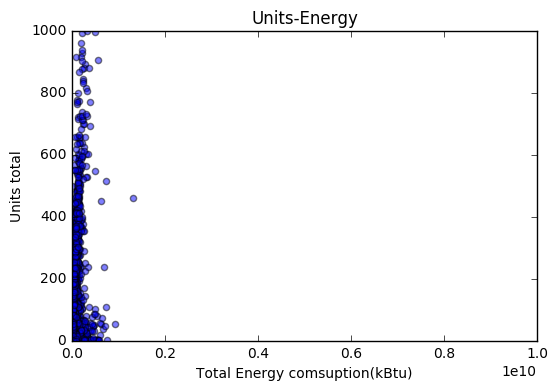

In [123]:
energy_unit=pl.scatter(total_energy,bblnrgdata['UnitsTotal'],alpha=0.5)
pl.ylim(0,1000)
pl.xlim(0,1e10)
plt.ylabel('Units total')
plt.xlabel('Total Energy comsuption(kBtu)')
plt.title('Units-Energy')


**Try to make a log plot instead**. 

In [129]:
bblnrgdata['total_energy']=total_energy

In [173]:
# to delete in dataframe the outliers
bblnrgdata = bblnrgdata[(bblnrgdata.total_energy > 1000) & (bblnrgdata["UnitsTotal"] > 10)]

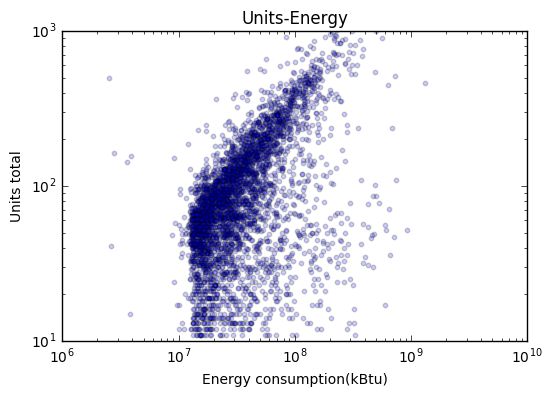

In [209]:
# if use loglog, then x , y shows the true value ,rather than the log value
ax=bblnrgdata.plot.scatter(x='total_energy',y='UnitsTotal',loglog=True,alpha=0.2,s=10)
ylim(10,1000)
xlim(1e6,1e10)
plt.xlabel("Energy consumption(kBtu)")
plt.ylabel("Units total")
plt.title("Units-Energy")

Now fit a line through the data. you can use whatever you want to do it: statsmodels, scipy, any other package, or write your own minimization of the residuals

## BUT REMEMBER: we see hints of a linear relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:
if you used statsmodels it would look something like this:


In [297]:
x=bblnrgdata.total_energy
y=bblnrgdata.UnitsTotal

In [298]:
X = sm.add_constant(np.log10(x))
linmodel = sm.OLS(np.log10(y), X, missing='drop').fit() # ignores entires 
                                                     # where x or y is NaN

In [299]:
Y=linmodel.predict()

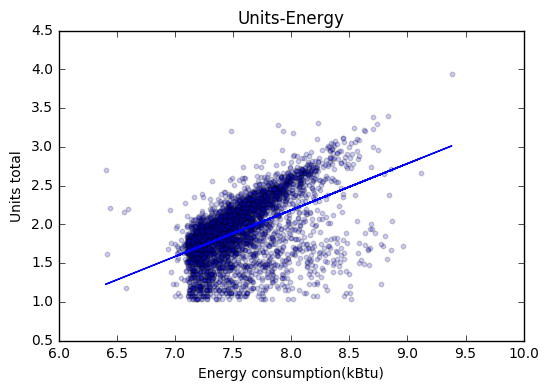

In [300]:
pl.scatter(log10(x),log10(y),alpha=0.2,s=10)
pl.plot(log10(x),Y)
#ylim(10,1000)
#xlim(1e6,1e10)
plt.xlabel("Energy consumption(kBtu)")
plt.ylabel("Units total")
plt.title("Units-Energy")

In [289]:
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     1409.
Date:                Sat, 15 Oct 2016   Prob (F-statistic):          1.74e-264
Time:                        16:38:42   Log-Likelihood:                -1444.2
No. Observations:                4003   AIC:                             2892.
Df Residuals:                    4001   BIC:                             2905.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const           -2.6170      0.121    -21.679      0.000        -2.854    -2.380
total_energy     0.5999      0.016     37.539      0.000         0.569     0.631
==============================================================================
Omnibus:                      385.140   Durbin-Watson:                   1.409
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              517.668
Skew:                          -0.793   Prob(JB):                    3.89e-113
Kurtosis:                       3.768   Cond. No.                         169.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [301]:
sigma= log10(y)/2
chisq=((Y-log10(y))**2/(sigma**2)).sum()
chisq

843.92970088797369

#   

In [302]:
y=bblnrgdata.total_energy
x=bblnrgdata.UnitsTotal
X = sm.add_constant(np.log10(x))
linmodel = sm.OLS(np.log10(y), X, missing='drop').fit() # ignores entires
Y=linmodel.predict()

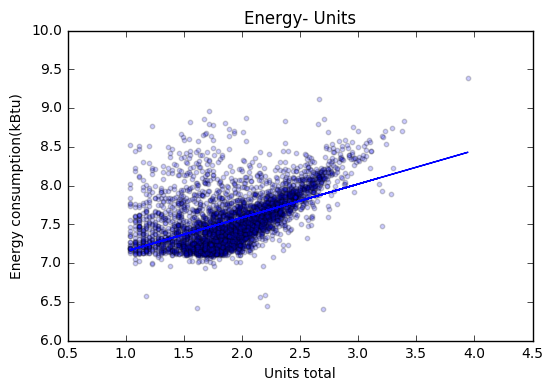

In [303]:
pl.scatter(log10(x),log10(y),alpha=0.2,s=10)
pl.plot(log10(x),Y)
#ylim(10,1000)
#xlim(1e6,1e10)
plt.ylabel("Energy consumption(kBtu)")
plt.xlabel("Units total")
plt.title("Energy- Units")

In [293]:
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_energy   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     1409.
Date:                Sat, 15 Oct 2016   Prob (F-statistic):          1.74e-264
Time:                        16:39:46   Log-Likelihood:                -796.94
No. Observations:                4003   AIC:                             1598.
Df Residuals:                    4001   BIC:                             1610.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.7163      0.023    297.491      0.000         6.672     6.761
UnitsTotal     0.4342      0.012     37.539      0.000         0.411     0.457
==============================================================================
Omnibus:                      994.718   Durbin-Watson:                   1.333
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2734.921
Skew:                           1.309   Prob(JB):                         0.00
Kurtosis:                       6.089   Cond. No.                         11.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [304]:
sigma= log10(y)/2
chisq=((Y-log10(y))**2/(sigma**2)).sum()
chisq

22.818623054864801

## Units total as independent variables, Energy as dependent variables is better

In [359]:
y=log10(bblnrgdata.total_energy)
x=log10(bblnrgdata.UnitsTotal)

In [358]:
data=pd.DataFrame()
data['x']=x
data['x2']=x**2
data['y']=y
data.head(2)

,x,x2,y
0,2.346353,5.505372,7.589013
2,1.278754,1.635211,7.472557


In [328]:
linmodel = smf.ols(formula='y~x+x2',data=data).fit()

In [342]:
x_pred = np.linspace(0,4.5,1000)

In [344]:
a = pd.DataFrame({"x": x_pred, "x2":x_pred**2})

In [349]:
# have to fit again ,according to new x, and it has to be a dataframe, with exact the same column name
linmodel.predict(a)

array([  8.4592481 ,   8.4528595 ,   8.44649006,   8.44013978,
         8.43380866,   8.4274967 ,   8.4212039 ,   8.41493025,
         8.40867577,   8.40244044,   8.39622428,   8.39002727,
         8.38384942,   8.37769073,   8.3715512 ,   8.36543083,
         8.35932962,   8.35324757,   8.34718467,   8.34114094,
         8.33511636,   8.32911094,   8.32312468,   8.31715758,
         8.31120964,   8.30528086,   8.29937124,   8.29348078,
         8.28760947,   8.28175733,   8.27592434,   8.27011052,
         8.26431585,   8.25854034,   8.25278399,   8.2470468 ,
         8.24132876,   8.23562989,   8.22995018,   8.22428962,
         8.21864823,   8.21302599,   8.20742291,   8.20183899,
         8.19627423,   8.19072863,   8.18520219,   8.1796949 ,
         8.17420678,   8.16873782,   8.16328801,   8.15785736,
         8.15244587,   8.14705354,   8.14168037,   8.13632636,
         8.13099151,   8.12567582,   8.12037928,   8.11510191,
         8.10984369,   8.10460464,   8.09938474,   8.09

In [365]:
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     1161.
Date:                Sat, 15 Oct 2016   Prob (F-statistic):               0.00
Time:                        17:12:21   Log-Likelihood:                -484.60
No. Observations:                4003   AIC:                             975.2
Df Residuals:                    4000   BIC:                             994.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.4592      0.070    120.441      0.000         8.322     8.597
x             -1.4204      0.072    -19.687      0.000        -1.562    -1.279
x2             0.4721      0.018     25.991      0.000         0.437     0.508
==============================================================================
Omnibus:                     1203.742   Durbin-Watson:                   1.393
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4874.982
Skew:                           1.430   Prob(JB):                         0.00
Kurtosis:                       7.588   Cond. No.                         110.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

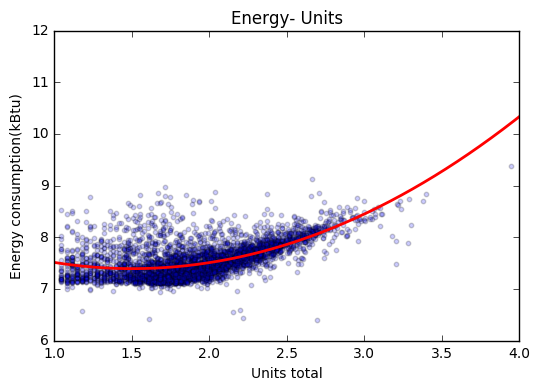

In [356]:
pl.scatter(x,y,alpha=0.2,s=10)
pl.plot(x_pred,linmodel.predict(a), "r-",linewidth=2)
pl.xlim(1,4)
plt.ylabel("Energy consumption(kBtu)")
plt.xlabel("Units total")
plt.title("Energy- Units")

In [367]:
LR = -2 * ((-796.94) - (-484.60))
LR

624.6800000000001

## Null hypothesis: Restricted model(y=ax+b) is better than y=ax2+bx+c
$ \alpha=5$ %

In [368]:
smf.ols(formula ='y~x+x2',data=data).fit().compare_lr_test(smf.ols(formula ='y~x',data=data).fit())

(624.68146596200495, 7.1706987712179677e-138, 1.0)

## Null hypothesis is rejected, so complicated model(y=ax2+bx+c) is better!

#  

###  

## Extra credit 1: calculate and plot the likelihood surface
Create a function that minimizes the residuals:

the residuals are the sum of the differences between data and model: in the case of a line fit model. Use the same function you created for the chi^2 test.

You should sum over each datapoints the residuals squared, which should look something like

(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2 / errors^2

where a and b are the parameters returned by the line fitter. 

For each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope.


You can write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


Lsurface = np.zeros((len(A), len(B)))
for i,a in enumerate(A):
    for j,b in enumerate(B):
         Lsurface[i][j] = np.nansum(residuals(a,b,data,errors)) .....

this gives you a 2D array that represents your likelihood surface! What we do to find a good fit is find the minimum (lowest point) on this surface.
You can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap" but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface)). Also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. Inputting your data in the cell below should give a plot similar to mine

In [375]:
data.head(3)

,x,x2,y
0,2.346353,5.505372,7.589013
2,1.278754,1.635211,7.472557
4,2.214844,4.905533,7.488543


In [377]:
def res(a,b):
    l=((y-x)*a+b)**2
    sigma2=(y/2)**2
    return(l/sigma2).sum()

In [379]:
A = np.arange(-50.0, 50.0, 0.5)
B = np.arange (-100, 100, 1)
Lsurface = np.zeros((len(A), len(B)))


In [381]:
for i,a in enumerate(A):
    for j,b in enumerate(B): 
        Lsurface[i][j] = np.nansum(res(a,b))

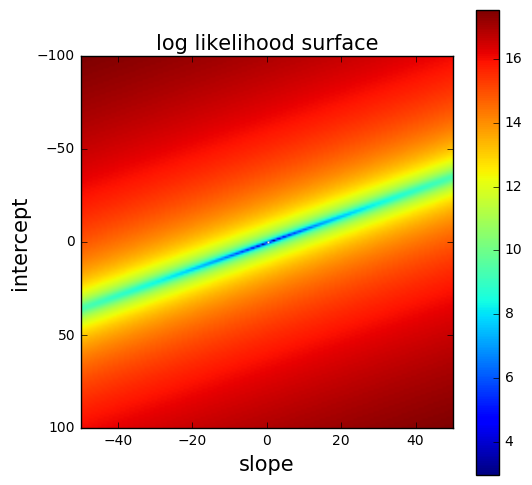

In [388]:
pl.figure(figsize=(6,6))
pl.title ("log likelihood surface", fontsize = 15)
pl.imshow(np.log(Lsurface), extent = [-50,50,100,-100], aspect=0.5)
plt.xlabel('slope', fontsize = 15)
plt.ylabel('intercept', fontsize = 15)
pl.colorbar()

## EXTRA CREDIT: get creative with the dataset. can you make an insigntful plot to show any structure in the data?

below I am mapping the building age to a colormap and the ratio of total to residential units to the size of the datapoint.

In [392]:
bblnrgdata.head(2)

,BBL,Reported NYC Building Identification Numbers (BINs),Street Number,Street Name,Borough,Zip Code,BBL on the Covered Buildings List,Site EUI(kBtu/ft2),Weather Normalized Site EUI(kBtu/ft2),Source EUI(kBtu/ft2),...,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry,total_energy
0,1.010950e+09,1027122,653,11 AVENUE,MANHATTAN,10036.0,Yes,108.8,106.4,253.1,...,1929,None,10036,M2-4,None,None,None,8c,"POLYGON ((985381.1289999932 217760.3027999997,...",38816175.3
2,1.008020e+09,1015051,122,WEST 27 STREET,MANHATTAN,10001.0,Yes,74.9,70.1,162.4,...,1912,None,10001,M1-6,None,None,None,8d,"POLYGON ((986448.734799996 210991.6014000028, ...",29686352.1


In [404]:
bblnrgdata['ENERGY STAR Score']=pd.to_numeric(bblnrgdata['ENERGY STAR Score'],errors='coerce')
bblnrgdata['Site EUI(kBtu/ft2)']=pd.to_numeric(bblnrgdata['Site EUI(kBtu/ft2)'],errors='coerce')

In [410]:
data2=pd.DataFrame(bblnrgdata['ENERGY STAR Score'])
data2['energy']=bblnrgdata['Site EUI(kBtu/ft2)']

In [414]:
data2 = data2[bblnrgdata['ENERGY STAR Score'] >1 ]

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [430]:
data2=data2.rename(columns={'ENERGY STAR Score':'star'})

In [454]:
line=smf.ols(formula='energy ~ star',data=data2).fit()

In [475]:
s=np.linspace(-10,110,1000)
data_pre=pd.DataFrame(s,columns=['star'])

In [463]:
energy_pre=line.predict(data_pre)

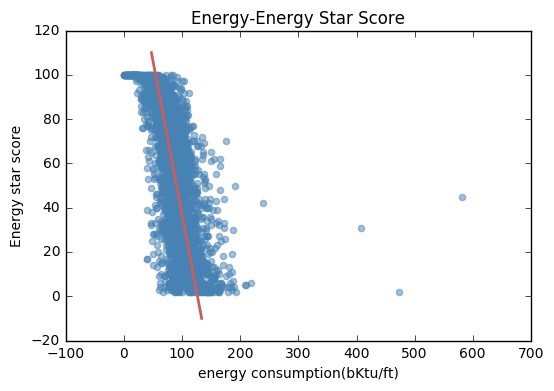

In [474]:
pl.scatter(data2['energy'],data2['star'],alpha=0.5,color='steelblue')
pl.plot(energy_pre,s,color='indianred',linewidth=2)
plt.ylabel('Energy star score')
plt.xlabel('energy consumption(bKtu/ft)')
plt.title('Energy-Energy Star Score')